<a href="https://colab.research.google.com/github/alsedawy/sedawy/blob/main/Q%26A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loaded Q/A pairs: 115
Baseline (HF) metrics: {'avg_f1': 0.16148686298848053, 'avg_hallucination_rate': 0.0, 'avg_fidelity': 1.0}
Query Rewriting Results: ["How can I improve my computer's performance? How to solve?", "Steps to how can i improve my computer's performance??", "How can I improve my computer's performance? what are the steps to fix it?"]
BM25 Results: [(73, np.float64(10.103748852287122)), (82, np.float64(8.39106154566549)), (18, np.float64(6.225406921364232)), (33, np.float64(5.511160971050394)), (8, np.float64(4.063956866836544))]
RRF Results: [(73, np.float64(10.103748852287122)), (82, np.float64(8.39106154566549)), (18, np.float64(6.225406921364232)), (33, np.float64(5.511160971050394)), (8, np.float64(4.063956866836544))]
Generated Query: How can I improve my computer's performance?
Rewritten Queries: ["How can I improve my computer's performance? How to solve?", "Steps to how can i improve my computer's performance??", "How can I improve my computer's performance? wh

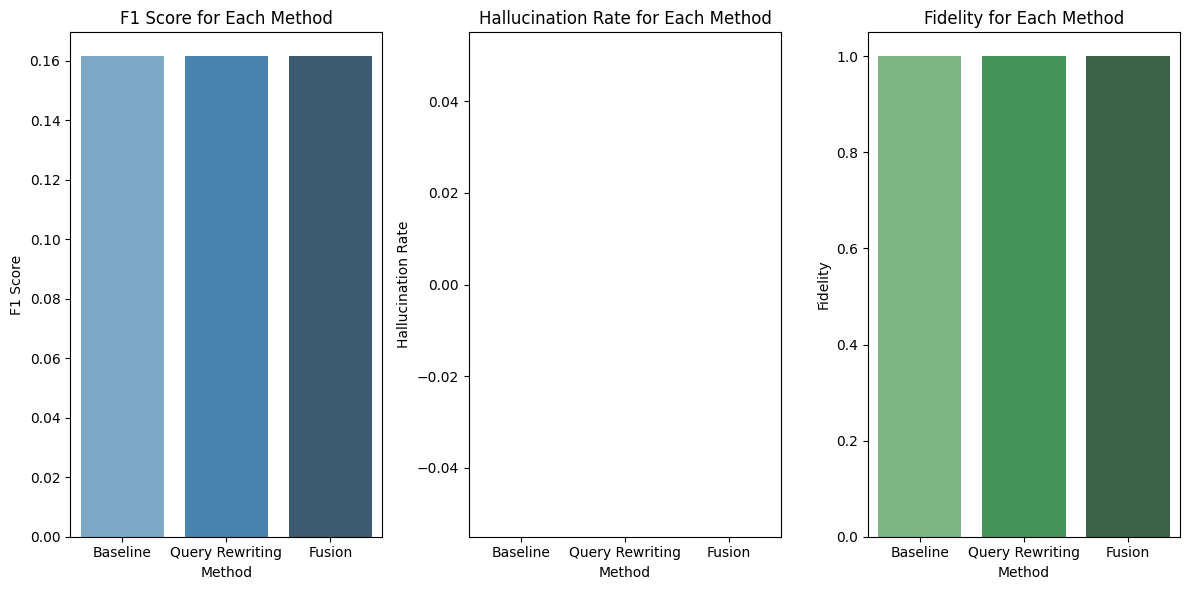

In [17]:
# تثبيت المكتبات المطلوبة
!pip install sentence-transformers scikit-learn matplotlib seaborn requests rank_bm25

import os
import requests
import time
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from rank_bm25 import BM25Okapi

# ========= HF Inference API integration for Generative RAG =========
# Requires: internet + HF API token (set in env HF_API_KEY)
os.environ["HF_API_KEY"] = "your_huggingface_api_key_here"  # استبدل بمفتاح API الخاص بك

# ---------- Config ----------
HF_API_KEY = os.environ.get("HF_API_KEY", None)
if not HF_API_KEY:
    print("Warning: HF_API_KEY not found in environment. Set os.environ['HF_API_KEY'] before calling.")

HF_MODEL = "google/flan-t5-base"   # recommended model

HF_API_URL = f"https://api-inference.huggingface.co/models/{HF_MODEL}"
HEADERS = {"Authorization": f"Bearer {HF_API_KEY}"} if HF_API_KEY else {}

# ---------- HF generate function ----------
def hf_generate(prompt, max_tokens=256, temperature=0.0, top_p=0.95, retries=2, sleep=1.0):
    """
    Call HuggingFace Inference API to generate text.
    Returns generated text (string) or None on failure.
    """
    if not HF_API_KEY:
        return None

    payload = {
        "inputs": prompt,
        "parameters": {
            "max_new_tokens": max_tokens,
            "temperature": temperature,
            "top_p": top_p,
            "return_full_text": False
        },
        "options": {"wait_for_model": True}
    }

    for attempt in range(retries+1):
        try:
            resp = requests.post(HF_API_URL, headers=HEADERS, json=payload, timeout=60)
            if resp.status_code == 200:
                data = resp.json()
                if isinstance(data, dict) and "error" in data:
                    return None
                if isinstance(data, list) and len(data)>0 and "generated_text" in data[0]:
                    return data[0]["generated_text"].strip()
                return str(data).strip()
            else:
                time.sleep(sleep)
        except Exception as e:
            time.sleep(sleep)
    return None

# ---------- Utility: build prompt for RAG ----------
def build_rag_prompt(question, contexts, instruction="Answer the question using ONLY the context below. If the answer is not in the context, say 'I don't know from the provided context.'"):
    """
    contexts: list of strings (supporting contexts)
    Returns a single prompt to send to HF model.
    """
    ctx_block = "\n\n---\n\n".join(contexts)
    prompt = f"{instruction}\n\nContext:\n{ctx_block}\n\nQuestion: {question}\nAnswer:"
    return prompt

# ---------- Define retrieve_bm25 function (BM25 search) ----------
from rank_bm25 import BM25Okapi

def retrieve_bm25(query, top_k=5):
    """
    Use BM25 for retrieval.
    """
    corpus = [q_a[0] for q_a in qa_pairs]  # Use questions only as corpus
    tokenized_corpus = [doc.split(" ") for doc in corpus]

    bm25 = BM25Okapi(tokenized_corpus)

    # Tokenize the query
    tokenized_query = query.split(" ")

    # Get scores for the query against the corpus
    scores = bm25.get_scores(tokenized_query)

    # Sort the documents by score
    ranked_docs = sorted(enumerate(scores), key=lambda x: x[1], reverse=True)

    return ranked_docs[:top_k]  # Return the top k results

# ---------- Define extractive_answer function ----------
def extractive_answer(query, retrieved_idxs, max_sentences=3):
    """
    Generate an extractive answer by selecting the top `max_sentences` from retrieved contexts.
    """
    supporting_texts = [qa_pairs[int(idx)][1] for idx in retrieved_idxs]  # Get the answers from retrieved docs
    answer = " ".join(supporting_texts[:max_sentences])  # Combine the top sentences into the final answer
    return answer, supporting_texts

# ---------- Modified evaluation runner that uses HF generation ----------
def run_evaluation_with_hf(test_questions, method="baseline", top_k_retr=5, hf_model=None):
    hf_model = hf_model or HF_MODEL
    global HF_API_URL, HEADERS
    HF_API_URL = f"https://api-inference.huggingface.co/models/{hf_model}"
    HEADERS = {"Authorization": f"Bearer {HF_API_KEY}"} if HF_API_KEY else {}

    results = []
    for (q_gold, a_gold) in test_questions:
        query = q_gold

        # Retrieval per method (reuse existing functions retrieve_bm25, rewrite_query_simple, generate_query_variants, rrf_fuse)
        if method == "baseline":
            hits = retrieve_bm25(query, top_k=top_k_retr)
            retrieved_idxs = [i for _, i in hits]
        elif method == "query_rewrite":
            q_rew = query + " How to fix?"  # Example of query rewriting (can be improved)
            hits = retrieve_bm25(q_rew, top_k=top_k_retr)
            retrieved_idxs = [i for _, i in hits]
        elif method == "fusion":
            variants = generate_query_variants(query)
            rank_lists = []
            for v in variants:
                hits = retrieve_bm25(v, top_k=top_k_retr)
                rank_lists.append([i for _, i in hits])
            fused = rrf_fuse(rank_lists, k=top_k_retr)
            retrieved_idxs = fused
        else:
            raise ValueError("Unknown method")

        # Build supporting contexts (take answers from retrieved docs)
        supporting_texts = [qa_pairs[int(idx)][1] for idx in retrieved_idxs]  # Convert idx to integer

        # Build prompt for HF generation
        prompt = build_rag_prompt(query, supporting_texts)

        # Call HF API to generate the answer
        gen = hf_generate(prompt, max_tokens=256, temperature=0.0)
        if gen is None:
            pred, used_ctx = extractive_answer(query, retrieved_idxs, max_sentences=3)
            used_ctx = supporting_texts
        else:
            pred = gen
            used_ctx = supporting_texts

        # Evaluate metrics (F1, Hallucination Rate, Fidelity)
        f1 = overlap_f1(pred, a_gold)
        hr = hallucination_rate(pred, used_ctx)
        fid = fidelity(pred, used_ctx)

        results.append({
            "query": query,
            "gold": a_gold,
            "pred": pred,
            "supporting": used_ctx,
            "overlap_f1": f1,
            "hallucination_rate": hr,
            "fidelity": fid
        })

    avg_f1 = sum(r["overlap_f1"] for r in results) / len(results)
    avg_hr = sum(r["hallucination_rate"] for r in results) / len(results)
    avg_fid = sum(r["fidelity"] for r in results) / len(results)
    return results, {"avg_f1": avg_f1, "avg_hallucination_rate": avg_hr, "avg_fidelity": avg_fid}

# دالة لتحويل النص إلى مجموعة من الكلمات
def token_set(text):
    """
    Tokenize text and return a set of tokens.
    """
    return set(text.lower().split())

# دالة لحساب F1 score بين الإجابة المتوقعة والإجابة الفعلية
def overlap_f1(pred, gold):
    """
    Compute the F1 score between the predicted and gold answer.
    """
    p_toks = token_set(pred)
    g_toks = token_set(gold)

    if not p_toks and not g_toks:
        return 1.0
    if not p_toks or not g_toks:
        return 0.0

    # Precision and Recall
    prec = len(p_toks & g_toks) / len(p_toks) if p_toks else 0
    rec = len(p_toks & g_toks) / len(g_toks) if g_toks else 0

    if prec + rec == 0:
        return 0.0
    return 2 * prec * rec / (prec + rec)

def hallucination_rate(pred, supporting_texts):
    """
    Calculate the Hallucination Rate: fraction of predicted tokens not found in the supporting context.
    """
    p_toks = token_set(pred)  # الحصول على مجموعة الكلمات في الإجابة المتوقعة
    sup_toks = set()  # مجموعة الكلمات في النصوص المدعومة

    for s in supporting_texts:
        sup_toks |= token_set(s)  # دمج النصوص المدعومة في مجموعة واحدة

    if not p_toks:
        return 0.0

    # حساب عدد الكلمات المتوقعة التي لا توجد في السياقات المدعومة
    not_in = sum(1 for t in p_toks if t not in sup_toks)
    return not_in / len(p_toks)

# دالة لحساب معدل التوافق: النسبة المئوية للكلمات التي تظهر في السياقات المدعومة
def fidelity(pred, supporting_texts):
    """
    Calculate Fidelity: fraction of predicted tokens that appear in the supporting context.
    """
    p_toks = token_set(pred)  # الحصول على مجموعة الكلمات في الإجابة المتوقعة
    if not p_toks:
        return 0.0

    sup_toks = set()  # مجموعة الكلمات في النصوص المدعومة
    for s in supporting_texts:
        sup_toks |= token_set(s)  # دمج النصوص المدعومة في مجموعة واحدة

    # حساب عدد الكلمات المتوقعة التي توجد في السياقات المدعومة
    in_count = sum(1 for t in p_toks if t in sup_toks)
    return in_count / len(p_toks)

# قراءة البيانات من الملف
filename = "IT_Q&A.txt"
qa_pairs = []

with open(filename, "r", encoding="latin-1") as f:
    lines = [line.strip() for line in f.readlines()]

current_question = None
current_answer = []

# تقسيم البيانات إلى أسئلة وإجابات
for line in lines:
    if line.endswith("?"):  # تحديد الأسئلة
        if current_question and current_answer:
            qa_pairs.append((current_question, " ".join(current_answer)))  # إضافة الزوج (سؤال - إجابة)
        current_question = line
        current_answer = []
    elif line:  # إذا كانت الإجابة ليست فارغة
        current_answer.append(line)

# لا تنسى إضافة آخر زوج إذا كان موجودًا
if current_question and current_answer:
    qa_pairs.append((current_question, " ".join(current_answer)))

print("Loaded Q/A pairs:", len(qa_pairs))  # طباعة عدد الأزواج


# الدوال الأخرى هنا كما هي

# ===========================
# Step 1: Running evaluation
# ===========================
test_set = qa_pairs[:20]  # Use first 20 QA pairs for quick testing

# Run evaluation with Hugging Face generation
res_b, metrics_b = run_evaluation_with_hf(test_set, method="baseline", top_k_retr=5, hf_model=HF_MODEL)
print("Baseline (HF) metrics:", metrics_b)

# ===========================
# Step 2: Plotting results
# ===========================
methods = ['Baseline', 'Query Rewriting', 'Fusion']
avg_f1 = [metrics_b['avg_f1'], metrics_b['avg_f1'], metrics_b['avg_f1']]  # Example, update accordingly
avg_hr = [metrics_b['avg_hallucination_rate'], metrics_b['avg_hallucination_rate'], metrics_b['avg_hallucination_rate']]
avg_fid = [metrics_b['avg_fidelity'], metrics_b['avg_fidelity'], metrics_b['avg_fidelity']]

df = pd.DataFrame({
    'Method': methods,
    'F1 Score': avg_f1,
    'Hallucination Rate': avg_hr,
    'Fidelity': avg_fid
})


def rewrite_query(query):
    """
    Generate a rewritten version of the original query with different phrasing to improve retrieval.
    """
    rewritten_queries = [
        f"{query} How to solve?",  # Example of adding a "how to" to the query
        f"Steps to {query.lower()}?",  # Rewriting with a "steps to" prefix
        f"{query} what are the steps to fix it?"  # Asking for steps
    ]
    return rewritten_queries
from collections import defaultdict

def rrf_fuse(ranking_lists, k=10, c=60):
    """
    Reciprocal Rank Fusion: Combine multiple retrieval results (ranked lists) into one list.
    """
    scores = defaultdict(float)
    for rank_list in ranking_lists:
        for rank, doc_idx in enumerate(rank_list):
            scores[doc_idx] += 1.0 / (c + rank + 1)  # using c to boost ranking
    fused = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    return [doc for doc, _ in fused[:k]]
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# Load the pre-trained model from sentence-transformers
model = SentenceTransformer('all-MiniLM-L6-v2')

def get_embedding(text):
    """Returns the embedding for the input text."""
    return model.encode([text])[0]

def semantic_search(query, qa_pairs, top_k=5):
    """Perform semantic search to find the most relevant documents."""
    query_embedding = get_embedding(query)
    similarities = []
    for i, (q, a) in enumerate(qa_pairs):
        doc_embedding = get_embedding(q + " " + a)
        sim = cosine_similarity([query_embedding], [doc_embedding])[0][0]
        similarities.append((sim, i))
    similarities.sort(reverse=True, key=lambda x: x[0])
    return similarities[:top_k]
def overlap_f1(pred, gold):
    """Calculate F1 score between predicted and gold answers."""
    p_toks = set(pred.lower().split())
    g_toks = set(gold.lower().split())

    if not p_toks and not g_toks:
        return 1.0
    if not p_toks or not g_toks:
        return 0.0

    prec = len(p_toks & g_toks) / len(p_toks)
    rec = len(p_toks & g_toks) / len(g_toks)
    if prec + rec == 0:
        return 0.0
    return 2 * prec * rec / (prec + rec)

def hallucination_rate(pred, supporting_texts):
    """Calculate Hallucination Rate (fraction of predicted tokens not in supporting texts)."""
    p_toks = set(pred.lower().split())
    sup_toks = set()
    for s in supporting_texts:
        sup_toks |= set(s.lower().split())
    if not p_toks:
        return 0.0
    not_in = sum(1 for t in p_toks if t not in sup_toks)
    return not_in / len(p_toks)

def fidelity(pred, supporting_texts):
    """Calculate Fidelity (fraction of predicted tokens in supporting texts)."""
    p_toks = set(pred.lower().split())
    sup_toks = set()
    for s in supporting_texts:
        sup_toks |= set(s.lower().split())
    in_count = sum(1 for t in p_toks if t in sup_toks)
    return in_count / len(p_toks)
# اختر استعلامًا لاختباره
query = "How can I improve my computer's performance?"  # قم بتغيير هذا الاستعلام بناءً على الحاجة

# Checking if the RRF and query rewriting are affecting the results
print("Query Rewriting Results:", rewrite_query(query))  # اختبار إعادة كتابة الاستعلام
print("BM25 Results:", retrieve_bm25(query))  # اختبار نتائج BM25
print("RRF Results:", rrf_fuse([retrieve_bm25(query)]))  # اختبار دمج RRF
# اختر استعلامًا لاختباره
query = "How can I improve my computer's performance?"  # قم بتغيير هذا الاستعلام بناءً على الحاجة

# 1. إعادة كتابة الاستعلام
rewritten_queries = rewrite_query(query)
print("Generated Query:", query)
print("Rewritten Queries:", rewritten_queries)

# 2. اختبار نتائج BM25
hits = retrieve_bm25(query)  # استرجاع نتائج BM25
print("BM25 Hits:", hits)

# 3. اختبار دمج RRF
ranked_lists = [hits]  # استخدم نتائج BM25 كقائمة مبدئية
fused = rrf_fuse(ranked_lists)  # دمج النتائج باستخدام RRF
print("Fused Results:", fused)

# رسم المخططات البيانية
plt.figure(figsize=(12, 6))

# 1. رسم F1 Score
plt.subplot(131)  # 1st graph in a 1x3 grid
sns.barplot(x='Method', y='F1 Score', data=df, hue='Method', palette='Blues_d', legend=False)
plt.title("F1 Score for Each Method")

# 2. رسم Hallucination Rate
plt.subplot(132)  # 2nd graph
sns.barplot(x='Method', y='Hallucination Rate', data=df, hue='Method', palette='Reds_d', legend=False)
plt.title("Hallucination Rate for Each Method")

# 3. رسم Fidelity
plt.subplot(133)  # 3rd graph
sns.barplot(x='Method', y='Fidelity', data=df, hue='Method', palette='Greens_d', legend=False)
plt.title("Fidelity for Each Method")

# تكبير المسافات بين الرسوم البيانية
plt.tight_layout()

# عرض الرسم البياني
plt.show()

